In [ ]:
"""
Implementation of paper: Learning Confidence for Out-of-Distribution Detection in Neural Networks
https://arxiv.org/pdf/1802.04865.pdf

Ref:
1. https://github.com/uoguelph-mlrg/confidence_estimation
2. https://blog.csdn.net/qq_22210253/article/details/85229988
3. http://blog.sina.com.cn/s/blog_a89e19440102x1el.html
4. https://medium.com/@chih.sheng.huang821/%E6%A9%9F%E5%99%A8-%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92-%E5%9F%BA%E7%A4%8E%E4%BB%8B%E7%B4%B9-%E6%90%8D%E5%A4%B1%E5%87%BD%E6%95%B8-loss-function-2dcac5ebb6cb
5. https://www.cnblogs.com/ranjiewen/p/10059490.html
"""

In [1]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import datasets, transforms
import torchvision

import seaborn as sns  # import this after torch or it will break everything

from tqdm import tqdm_notebook, tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Load Data (transforms)

In [2]:
# normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
#                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

train_transform = transforms.Compose([])    
# train_transform.transforms.append(transforms.RandomHorizontalFlip())
train_transform.transforms.append(transforms.RandomCrop(28, padding=4))
train_transform.transforms.append(transforms.ToTensor())
# train_transform.transforms.append(normalize)
# if args.cutout > 0:
#     train_transform.transforms.append(Cutout(args.cutout))

# test_transform = transforms.Compose([
#     transforms.ToTensor(),
#     normalize])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load的時候就直接進行轉換
mnist_train = datasets.MNIST(
    root='./mnist/',    # 保存或者提取位置
    train=True,  # this is training data
    transform=train_transform,    # 转换 PIL.Image or numpy.ndarray 成
    # torchvision.transforms.ToTensor(), torch.FloatTensor (C x H x W), 训练的时候 normalize 成 [0.0, 1.0] 区间
    download=True          # 没下载就下载, 下载了就不用再下了
)
mnist_test = datasets.MNIST(
    root='./mnist/',    # 保存或者提取位置
    train=False,  # this is training data
    transform=test_transform,    # 转换 PIL.Image or numpy.ndarray 成
    # torchvision.transforms.ToTensor(), torch.FloatTensor (C x H x W), 训练的时候 normalize 成 [0.0, 1.0] 区间
    download=True          # 没下载就下载, 下载了就不用再下了
)

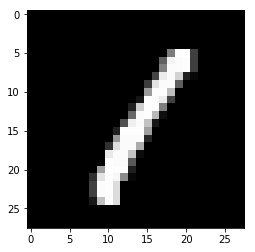

In [173]:
plt.imshow(mnist_train.train_data[3], cmap='gray')

### dataloader

In [3]:
X_train, y_train = mnist_train.train_data, mnist_train.train_labels
X_test, y_test = mnist_test.test_data, mnist_test.test_labels

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# for batch training - 50 samples, 1 channel, 28x28 (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=16)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=2)

torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([10000, 28, 28]) torch.Size([10000])


### Create own loader

In [4]:
import torch.utils.data as Data

x = torch.linspace(1, 10, 10)       # x data (torch tensor)
y = torch.linspace(10, 1, 10)       # y data (torch tensor)

# 先转换成 torch 能识别的 Dataset
torch_dataset = Data.TensorDataset(x, y)

# 把 dataset 放入 DataLoader
loader = Data.DataLoader(
    dataset=torch_dataset,      # torch TensorDataset format
    batch_size=10,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=2,              # 多线程来读数据
)

torch.Size([1, 28, 28])


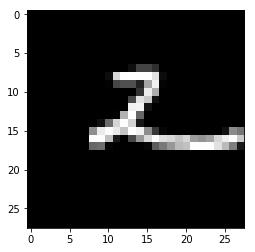

In [5]:
for image, label in train_loader:
#     print(label)
    print(image[0].shape)
    plt.imshow(image[0].reshape(28, 28), cmap='gray')
    break

## Model Building

In [16]:
num_classes = 10

# 卷積後長寬: [(n + 2p - k) / s] + 1
# n 原圖（input）長寬，p為padding，k是filter的kernel size， s是stride值
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(  # (1, 28, 28)
            nn.Conv2d(in_channels=1,
                      out_channels=16,  # output feature maps (filters)
                      kernel_size=5,
                      stride=1,
                      padding=2 # 上下左右都padding 2
                     ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # (16, 14, 14)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # (32, 7, 7)
        )
        # self.softmax = nn.Softmax()
        
        self.classifier = nn.Linear(32 * 7 * 7, num_classes)  # 
        self.confidence = nn.Linear(32 * 7 * 7, 1)
             
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # 展平多维的卷积图成 (batch_size, 32 * 7 * 7); 寫法:x.size()[0]也可
        pred = self.classifier(x)
        confidence = self.confidence(x)
        return pred, confidence

cnn = CNN()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=1568, out_features=10, bias=True)
  (confidence): Linear(in_features=1568, out_features=1, bias=True)
)


## Utils

In [13]:
class CSVLogger():
    def __init__(self, filename='log.csv', fieldnames=['epoch']):

        self.filename = filename
        self.csv_file = open(filename, 'w')

        # Write model configuration at top of csv
        writer = csv.writer(self.csv_file)
#         for arg in vars(args):
#             writer.writerow([arg, getattr(args, arg)])
        writer.writerow([''])

        self.writer = csv.DictWriter(self.csv_file, fieldnames=fieldnames)
        self.writer.writeheader()

        self.csv_file.flush()

    def writerow(self, row):
        self.writer.writerow(row)
        self.csv_file.flush()

    def close(self):
        self.csv_file.close()
        
# one hot encoding
def encode_onehot(labels, n_classes):
    onehot = torch.FloatTensor(labels.size()[0], n_classes)
    labels = labels.data
    if labels.is_cuda:
        onehot = onehot.cuda()
    onehot.zero_()
    onehot.scatter_(1, labels.view(-1, 1), 1)
    return onehot

# Example
# onehot = torch.FloatTensor(1, 10)
# onehot.zero_()
# onehot.scatter_(1, torch.tensor([[2]]), 1)

In [9]:
def plot_histograms(correct, confidence, bins=50, norm_hist=True):
    # Plot histogram of correctly classified and misclassified examples in visdom
    global conf_histogram

    plt.figure(figsize=(6, 4))
    sns.distplot(confidence[correct], kde=False, bins=bins, norm_hist=norm_hist, label='Correct')
    sns.distplot(confidence[np.invert(correct)], kde=False, bins=bins, norm_hist=norm_hist, label='Incorrect')
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.legend()

    # the image buffer acts as if it where a location on disk
#     img_buffer = BytesIO()
#     plt.savefig(img_buffer, bbox_inches='tight', pad_inches=0)
#     img = Image.open(img_buffer)
#     img = img.convert('RGB')
#     img = torch.FloatTensor(np.array(img)).permute(2, 0, 1)
#     conf_histogram = vis.image(img, win=conf_histogram, opts=dict(title='Confidence Histogram'))

def test(loader):
    cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).

    correct = []
    probability = []
    confidence = []

    for images, labels in loader:
        with torch.no_grad():
            images = Variable(images)  # .cuda()
        labels = labels  # .cuda()
        
        pred, conf = cnn(images)
        pred = torch.softmax(pred, dim=-1)
        conf = torch.sigmoid(conf).data.view(-1)

        pred_value, pred = torch.max(pred.data, 1)
        correct.extend((pred == labels).cpu().numpy())  # 猜中label數目是多少
        probability.extend(pred_value.cpu().numpy())  # 猜的機率是多少
        confidence.extend(conf.cpu().numpy())  # 信心度是多少

    correct = np.array(correct).astype(bool)
    probability = np.array(probability)
    confidence = np.array(confidence)

    # plot_histograms(correct, probability)
    plot_histograms(correct, confidence)

    val_acc = np.mean(correct)
    conf_min = np.min(confidence)
    conf_max = np.max(confidence)
    conf_avg = np.mean(confidence)

    cnn.train()
    return val_acc, conf_min, conf_max, conf_avg

## Training

In [17]:
cnn = CNN()
learning_rate = 0.1

prediction_criterion = nn.NLLLoss()
cnn_optimizer = torch.optim.SGD(cnn.parameters(), lr=learning_rate,
                                momentum=0.9, nesterov=True, weight_decay=5e-4)
# https://zhuanlan.zhihu.com/p/39020473 (Learning Rate in PyTorch)
scheduler = MultiStepLR(cnn_optimizer, milestones=[10, 20, 25], gamma=0.2)

test_acc: 0.977, conf_min: 0.098, conf_max: 0.998, conf_avg: 0.833


test_acc: 0.973, conf_min: 0.099, conf_max: 0.994, conf_avg: 0.684


test_acc: 0.984, conf_min: 0.088, conf_max: 0.993, conf_avg: 0.665


test_acc: 0.981, conf_min: 0.041, conf_max: 0.994, conf_avg: 0.639


test_acc: 0.986, conf_min: 0.067, conf_max: 0.996, conf_avg: 0.710


test_acc: 0.984, conf_min: 0.059, conf_max: 0.993, conf_avg: 0.654


test_acc: 0.990, conf_min: 0.064, conf_max: 0.991, conf_avg: 0.679


test_acc: 0.990, conf_min: 0.130, conf_max: 0.993, conf_avg: 0.775


test_acc: 0.987, conf_min: 0.020, conf_max: 0.987, conf_avg: 0.604


test_acc: 0.987, conf_min: 0.048, conf_max: 0.983, conf_avg: 0.620


test_acc: 0.986, conf_min: 0.035, conf_max: 0.997, conf_avg: 0.618


test_acc: 0.991, conf_min: 0.046, conf_max: 0.995, conf_avg: 0.677


test_acc: 0.992, conf_min: 0.065, conf_max: 0.994, conf_avg: 0.751


test_acc: 0.992, conf_min: 0.067, conf_max: 0.997, conf_avg: 0.755


test_acc: 0.992, conf_min: 0.049, conf_max: 0.992, conf_avg: 0.669


test_acc: 0.992, conf_min: 0.052, conf_max: 0.994, conf_avg: 0.693


test_acc: 0.991, conf_min: 0.039, conf_max: 0.986, conf_avg: 0.666


test_acc: 0.992, conf_min: 0.033, conf_max: 0.977, conf_avg: 0.556


test_acc: 0.991, conf_min: 0.040, conf_max: 0.987, conf_avg: 0.642


test_acc: 0.992, conf_min: 0.057, conf_max: 0.990, conf_avg: 0.661


test_acc: 0.992, conf_min: 0.053, conf_max: 0.993, conf_avg: 0.732


test_acc: 0.993, conf_min: 0.040, conf_max: 0.987, conf_avg: 0.663


test_acc: 0.993, conf_min: 0.040, conf_max: 0.987, conf_avg: 0.645


test_acc: 0.993, conf_min: 0.044, conf_max: 0.990, conf_avg: 0.658


test_acc: 0.992, conf_min: 0.047, conf_max: 0.991, conf_avg: 0.674


test_acc: 0.993, conf_min: 0.036, conf_max: 0.986, conf_avg: 0.631


test_acc: 0.994, conf_min: 0.039, conf_max: 0.988, conf_avg: 0.656


test_acc: 0.993, conf_min: 0.037, conf_max: 0.987, conf_avg: 0.648


test_acc: 0.993, conf_min: 0.039, conf_max: 0.987, conf_avg: 0.646


test_acc: 0.993, conf_min: 0.041, conf_max: 0.988, conf_avg: 0.659


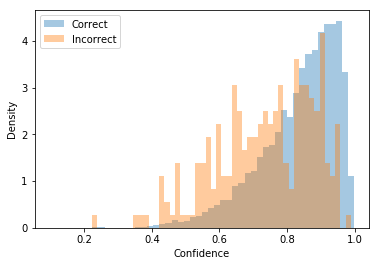

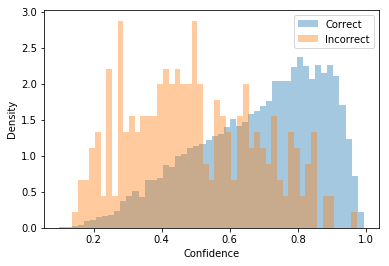

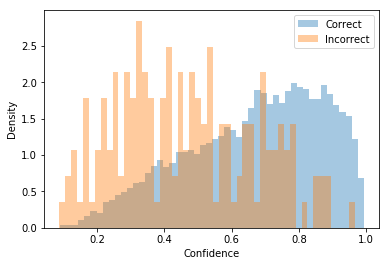

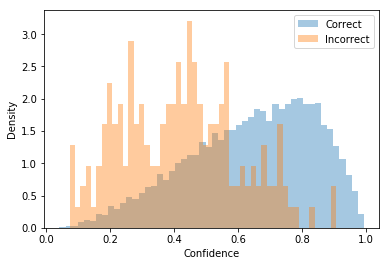

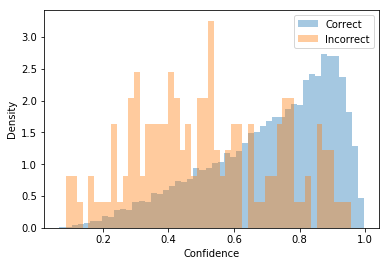

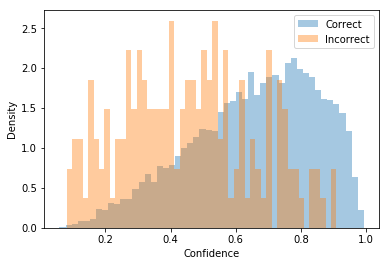

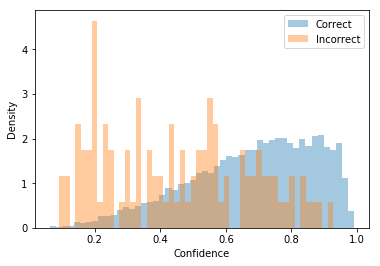

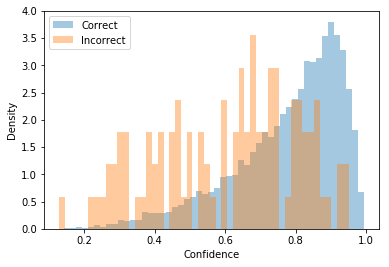

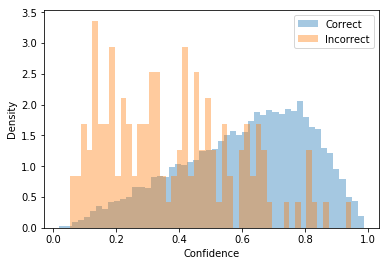

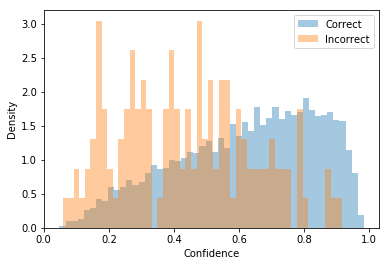

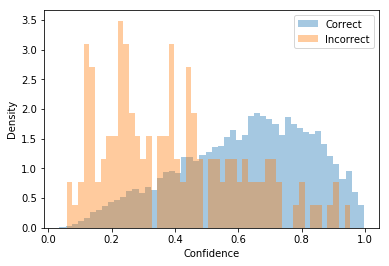

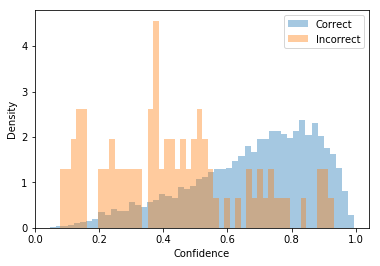

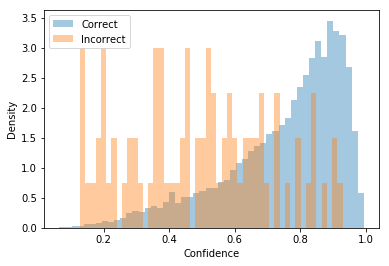

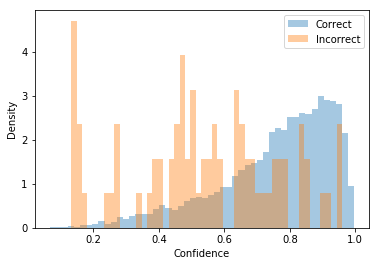

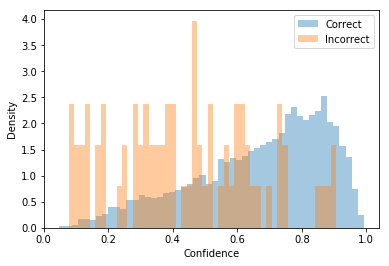

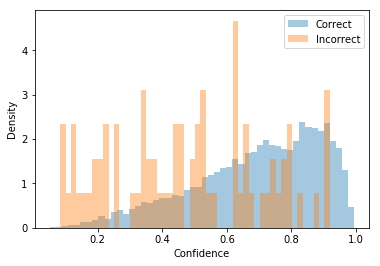

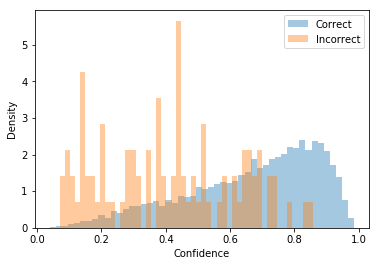

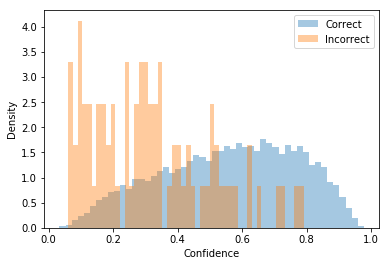

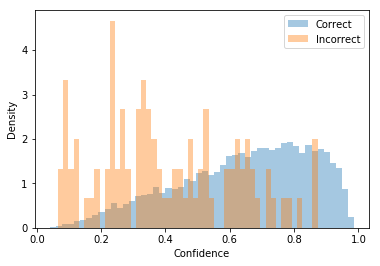

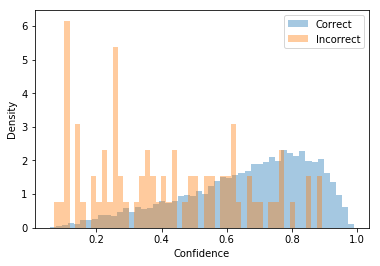

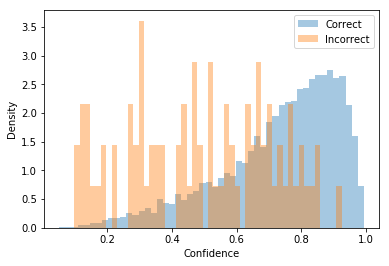

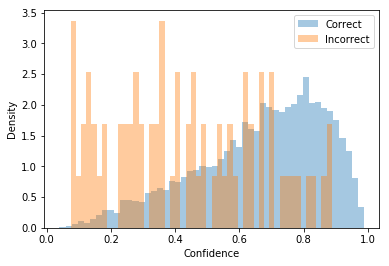

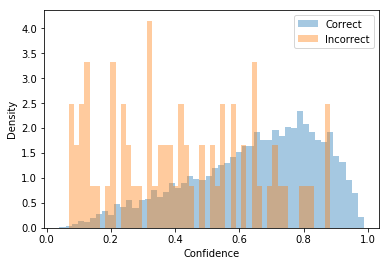

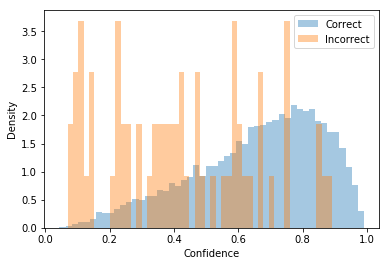

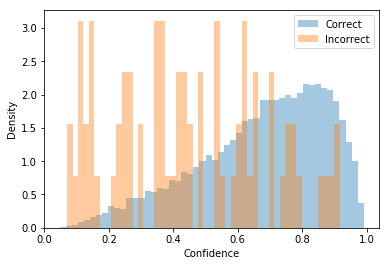

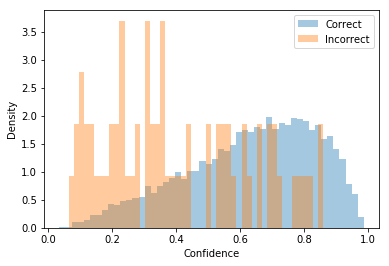

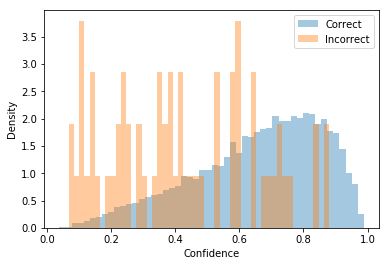

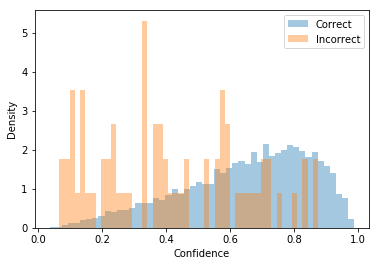

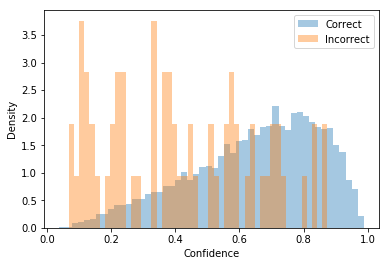

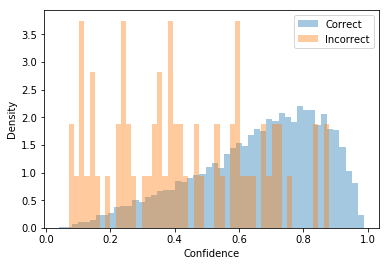

In [18]:
# __.data[0]會報錯，要用__.item()
# .data -> Tensor, .item -> scalar

csv_logger = CSVLogger(fieldnames=['epoch', 'train_acc', 'test_acc'])

np.random.seed(2019)
# Start with a reasonable guess for lambda
epochs = 30
lmbda = 0.1
budget = 0.6  # budget給多才敢用hint

for epoch in range(epochs):

    xentropy_loss_avg = 0.
    confidence_loss_avg = 0.
    correct_count = 0.
    total = 0.
    
    progress_bar = tqdm_notebook(train_loader)
    for i, (images, labels) in enumerate(progress_bar):
        progress_bar.set_description('Epoch ' + str(epoch))
        
        # images = Variable(images).cuda(async=True)
        images = Variable(images)
        # labels = Variable(labels).cuda(async=True)
        labels = Variable(labels)
        labels_onehot = Variable(encode_onehot(labels, num_classes))
        
        cnn.zero_grad()
        
        pred_original, confidence = cnn(images)
        
        pred_original = torch.softmax(pred_original, dim=-1)
        confidence = torch.sigmoid(confidence)
        
        # Make sure we don't have any numerical instability
        eps = 1e-12
        pred_original = torch.clamp(pred_original, 0. + eps, 1. - eps)  # 等於clip
        confidence = torch.clamp(confidence, 0. + eps, 1. - eps)

        # Randomly set half of the confidences to 1 (i.e. no hints)
        b = Variable(torch.bernoulli(torch.Tensor(confidence.size()).uniform_(0, 1)))  # .cuda()
        conf = confidence * b + (1 - b)  # mask=0的confidence=1
        # p_prime = p * c + y * (1 - c)
        pred_new = pred_original * conf.expand_as(pred_original) + labels_onehot * (1 - conf.expand_as(labels_onehot))
        pred_new = torch.log(pred_new)  # 這裡要再開log; nn.CrossEntropy = nn.LogSoftmax + nn.NLLLoss 
        
        xentropy_loss = prediction_criterion(pred_new, labels)
        confidence_loss = torch.mean(-torch.log(confidence))  # 信心越高，loss越低  -torch.log(torch.Tensor([0.75]))
        
        total_loss = xentropy_loss + (lmbda * confidence_loss)
        
        # if conf_loss >= budget -> increase lambda (hint is more expensive)
        # if conf_loss < budget -> decrease lambda (hint is more affordable)
        # budget 0.3 信心大概要平均大於0.75才不會超過
        
        if budget > confidence_loss.item():
            lmbda = lmbda / 1.01
        elif budget <= confidence_loss.item():
            lmbda = lmbda / 0.99
        
        total_loss.backward()
        cnn_optimizer.step()
        
        xentropy_loss_avg += xentropy_loss.item()
        confidence_loss_avg += confidence_loss.item()
        
        pred_idx = torch.max(pred_original.data, 1)[1]
        total += labels.size(0)
        
        correct_count += (pred_idx == labels.data).sum().item()
        accuracy = correct_count / total
        
        progress_bar.set_postfix(
            xentropy='%.3f' % (xentropy_loss_avg / (i + 1)),
            confidence_loss='%.3f' % (confidence_loss_avg / (i + 1)),
            acc='%.3f' % accuracy)
    
    test_acc, conf_min, conf_max, conf_avg = test(test_loader)
    tqdm.write('test_acc: %.3f, conf_min: %.3f, conf_max: %.3f, conf_avg: %.3f' % (test_acc, conf_min, conf_max, conf_avg))

    scheduler.step(epoch)

    row = {'epoch': str(epoch), 'train_acc': str(accuracy), 'test_acc': str(test_acc)}
    csv_logger.writerow(row)

    torch.save(cnn.state_dict(), 'checkpoints/' + 'state_dict' + '.pt')

csv_logger.close()

In [88]:
60000 - correct_count

534.0

### Predict samples

In [158]:
cnn.eval()
idx = 100
# print(mnist_test.test_data[idx].shape)
print("Label:", test_loader.dataset.test_labels[idx])
img = test_loader.dataset.test_data[idx][None, None].type("torch.FloatTensor")
print(img.type())
# x = torch.unsqueeze(mnist_test.test_data[11:12], dim=0)
print("input_shape:", img.shape)

with torch.no_grad():
    img = Variable(img)
pred, conf = cnn(img)
pred = torch.softmax(pred, dim=-1)
conf = torch.sigmoid(conf).data.view(-1)

print("prediction:", pred)
print("confidence:", conf.cpu().numpy())

pred_value, pred = torch.max(pred.data, 1)
print("pred_value:", pred_value)
print("pred label:", pred)

cnn.train()
# correct.extend((pred == labels).cpu().numpy())  # 猜中label數目是多少
# probability.extend(pred_value.cpu().numpy())  # 猜的機率是多少
# confidence.extend(conf.cpu().numpy())  # 信心度是多少

Label: tensor(6)
torch.FloatTensor
input_shape: torch.Size([1, 1, 28, 28])
prediction: tensor([[2.2588e-03, 5.5710e-11, 8.3192e-09, 8.5046e-11, 2.4054e-05, 5.1761e-11,
         1.1051e-02, 9.8572e-01, 9.4519e-04, 9.2490e-12]],
       grad_fn=<SoftmaxBackward>)
confidence: [0.01632771]
pred_value: tensor([0.9857])
pred label: tensor([7])


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=1568, out_features=10, bias=True)
  (confidence): Linear(in_features=1568, out_features=1, bias=True)
)

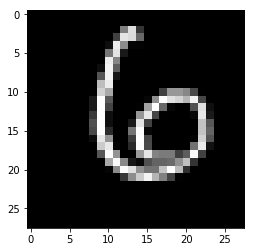

In [160]:
plt.imshow(test_loader.dataset.test_data[idx].numpy(), cmap='gray')

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=1568, out_features=10, bias=True)
  (confidence): Linear(in_features=1568, out_features=1, bias=True)
)

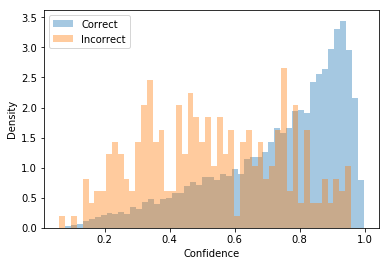

In [133]:
cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).

correct = []
probability = []
confidence = []

for images, labels in test_loader:
    with torch.no_grad():
        images = Variable(images)  # .cuda()
    
    labels = labels  # .cuda()

    pred, conf = cnn(images)
    pred = torch.softmax(pred, dim=-1)
    conf = torch.sigmoid(conf).data.view(-1)

    pred_value, pred = torch.max(pred.data, 1)
    correct.extend((pred == labels).cpu().numpy())  # 猜中label數目是多少
    probability.extend(pred_value.cpu().numpy())  # 猜的機率是多少
    confidence.extend(conf.cpu().numpy())  # 信心度是多少

correct = np.array(correct).astype(bool)
probability = np.array(probability)
confidence = np.array(confidence)

# plot_histograms(correct, probability)
plot_histograms(correct, confidence)
cnn.train()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=1568, out_features=10, bias=True)
  (confidence): Linear(in_features=1568, out_features=1, bias=True)
)

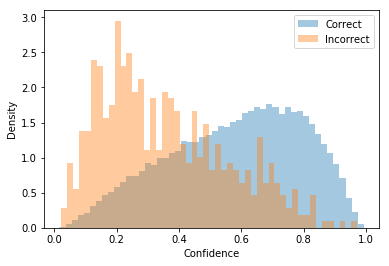

In [19]:
cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).

correct = []
probability = []
confidence = []

for images, labels in train_loader:
    with torch.no_grad():
        images = Variable(images)  # .cuda()
    
    labels = labels  # .cuda()

    pred, conf = cnn(images)
    pred = torch.softmax(pred, dim=-1)
    conf = torch.sigmoid(conf).data.view(-1)

    pred_value, pred = torch.max(pred.data, 1)
    correct.extend((pred == labels).cpu().numpy())  # 猜中label數目是多少
    probability.extend(pred_value.cpu().numpy())  # 猜的機率是多少
    confidence.extend(conf.cpu().numpy())  # 信心度是多少

correct = np.array(correct).astype(bool)
probability = np.array(probability)
confidence = np.array(confidence)

# plot_histograms(correct, probability)
plot_histograms(correct, confidence)
cnn.train()

In [134]:
confidence

array([0.9061311 , 0.9900648 , 0.8245051 , ..., 0.30977502, 0.38897344,
       0.9333509 ], dtype=float32)

In [22]:
print(-torch.log(torch.Tensor([0.75])))
print(torch.max(torch.Tensor([[0, 1, 4, 3]]), 1))

tensor([0.2877])
(tensor([4.]), tensor([2]))


In [32]:
"""
# torch.bernoulli
"""
a = torch.Tensor(3, 3).uniform_(0, 1)
print(a)
print(torch.bernoulli(a))

"""
# expand_as
"""
c = torch.Tensor(1, 1)
print(c)
print(c.expand_as(torch.Tensor(1, 10)))

tensor([[0.2512, 0.5365, 0.1805],
        [0.2364, 0.5587, 0.9278],
        [0.2939, 0.5346, 0.8124]])
tensor([[0., 1., 0.],
        [0., 1., 1.],
        [0., 0., 1.]])
tensor([[7.9003e+27]])
tensor([[7.9003e+27, 7.9003e+27, 7.9003e+27, 7.9003e+27, 7.9003e+27, 7.9003e+27,
         7.9003e+27, 7.9003e+27, 7.9003e+27, 7.9003e+27]])
